1. Desarrollar un modelo de regresión lineal para la
predicción de la masa de mangos basado una foto
2. Usar los descriptores (características) de imágenes
vistas en clase
3. Usar herramientas vistas en clase: umbralización,
equalización, operaciones morfológicas
4. Evaluar el modelo con el error absoluto medio en el
“split” de evaluación

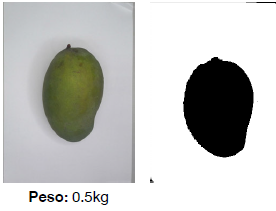

DATASET:
https://drive.google.com/file/d/1npNr2ZsS_inK54u8Jml96FdhRVB89ZYd/view?usp=share_link

In [1]:
# Se importan las librerías necesarias
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from skimage.feature import hog, local_binary_pattern
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

## Carga y visualiza imagenes del dataset con sus respectivos pesos



In [2]:
# Carga imágenes y etiquetas de la masa de mango
def carga_imagenes(folder_path, masa_csv):
    import os
    import numpy as np
    import cv2
    import pandas as pd

    # Cargar el archivo CSV, ignorando la primera fila (encabezado)
    masa_dict = {}
    with open(masa_csv, 'r') as file:
        next(file)  # Ignorar la primera fila (encabezado)
        for line in file:
            try:
                img_file, masa = line.strip().split(',')
                masa_dict[img_file] = float(masa)
            except ValueError:
                # Ignorar las líneas que no tienen un valor numérico válido para la masa
                continue

    # Cargar las imágenes
    X = []
    y = []
    for img_file in os.listdir(folder_path):
        if img_file in masa_dict:
            # Cargar la imagen
            img_path = os.path.join(folder_path, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                # Convertir la imagen en una característica (por ejemplo, vector de píxeles)
                X.append(img.flatten())  # Asegúrate de que el formato sea un vector
                y.append(masa_dict[img_file])

    # Convertir las listas a arrays de NumPy
    X = np.array(X)
    y = np.array(y)

    return X, y

In [3]:
# Carga imágenes y etiquetas de la masa de mango
def carga_imagenes(folder_path, masa_csv):
    features = []
    labels = []

    # Cargar las etiquetas de masa desde un archivo CSV
    masa_dict = {}
    with open(masa_csv, 'r') as file:
        for line in file:
            img_file, masa = line.strip().split(',')
            masa_dict[img_file] = float(masa)

    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)
        image = cv2.imread(img_path)
        if image is not None:
            image = cv2.resize(image, (128, 128))
            feature_vector = extract_features(image)
            if feature_vector is not None and feature_vector.size > 0:
                features.append(feature_vector)
                labels.append(masa_dict[img_file])  # Asigna la masa correspondiente
        else:
            print(f"Error cargando la imagen: {img_path}")

    return np.array(features), np.array(labels)



In [4]:
# Ruta a la carpeta con imágenes y al CSV con las masas de mango
folder_path = '/content/drive/MyDrive/ComputerVision/Ejercicios/Semana07/MangoMass/images'
masa_csv = '/content/drive/MyDrive/ComputerVision/Ejercicios/Semana07/MangoMass/Harumanis_mango_weight.csv'
data = pd.read_csv(masa_csv)
# Crear un diccionario con los nombres de imagenes y sus respectivos pesos
image_to_weight = dict(zip(data['no'], data['weight']))

# Listar todas las imágenes en la carpeta
image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Crear una lista para almacenar las imágenes que coinciden con el CSV
matched_images = []

In [5]:
# Recorrer cada imagen en el folder y verificar si está en el CSV
for image_file in image_files:
    if image_file in image_to_weight:
        # Obtener el peso correspondiente de la imagen
        weight = image_to_weight[image_file]

        # Leer la imagen usando OpenCV
        image_path = os.path.join(folder_path, image_file)
        image = cv2.imread(image_path)

        if image is not None:
            matched_images.append((image_file, image, weight))
        else:
            print(f"No se pudo leer la imagen: {image_file}")

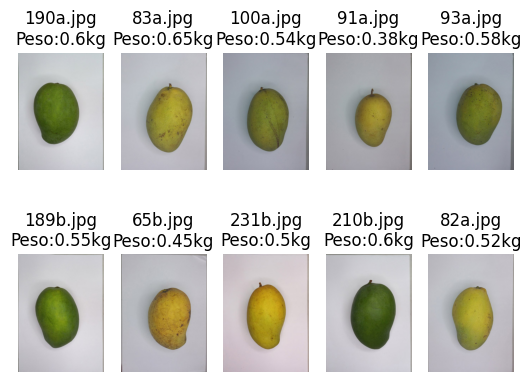

In [6]:
# Mostrar las primeras 10 imágenes y sus pesos
for i, (image_file, image, weight) in enumerate(matched_images[:10]):
    # Convertir la imagen de BGR a RGB para mostrar correctamente con matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Mostrar la imagen
    plt.subplot(2, 5, i+1)  # Crear una cuadrícula de 2 filas y 5 columnas
    plt.imshow(image_rgb)
    plt.title(f"{image_file}\nPeso:{weight}kg")
    plt.axis('off')  # Ocultar los ejes

# Mostrar las imágenes en una ventana
plt.show()

print(f"Total de imágenes coincidentes: {len(matched_images)}")

## Extrae las características de cada imagen

In [7]:
# Función para extraer características de la imagen
def extract_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Aplica umbralización
    _, thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)

    # Aplica equalización de histograma
    equalized = cv2.equalizeHist(gray)

    # Aplica operaciones morfológicas
    kernel = np.ones((5, 5), np.uint8)
    morph = cv2.morphologyEx(equalized, cv2.MORPH_OPEN, kernel)

    # Extrae características HOG
    hog_features, _ = hog(morph, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)

    # Crea histograma de intensidades
    hist = cv2.calcHist([morph], [0], None, [256], [0, 256]).flatten()

    # LBP (Local Binary Patterns)
    lbp = local_binary_pattern(morph, P=8, R=1, method="uniform")
    lbp_hist, _ = np.histogram(lbp, bins=np.arange(0, 59), range=(0, 58))

    # Extrae momentos de Hu
    moments = cv2.moments(thresh)
    hu_moments = cv2.HuMoments(moments).flatten()

    # Concatena todas las características en un vector
    features = np.hstack([hog_features, hist, lbp_hist, hu_moments])

    return features

Total de imágenes coincidentes: 546


In [8]:
# Lista para almacenar características y pesos
X = []
y = []

In [9]:
# Recorrer cada imagen en el folder y extraer características
for image_file in image_files:
    if image_file in image_to_weight:
        # Obtener el peso correspondiente de la imagen
        weight = image_to_weight[image_file]

        # Leer la imagen usando OpenCV
        image_path = os.path.join(folder_path, image_file)
        image = cv2.imread(image_path)

        if image is not None:
            # Extraer características de la imagen
            features = extract_features(image)
            X.append(features)
            y.append(weight)
        else:
            print(f"No se pudo leer la imagen: {image_file}")

In [10]:
# Convertir listas a arrays numpy
X = np.array(X)
y = np.array(y)

## Aplica la regresión lineal

In [11]:
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo de regresión lineal
model = LinearRegression()

# Entrenar el modelo
model.fit(X_train, y_train)

# Hacer predicciones en los datos de prueba
y_pred = model.predict(X_test)

# Calcular el error absoluto medio
mae = mean_absolute_error(y_test, y_pred)

print(f"Error Absoluto Medio: {mae}")

Error Absoluto Medio: 0.044847903592263635


In [12]:
# Mostrar los primeros 10 valores reales y predichos
for i in range(min(10, len(y_test))):
    print(f"Peso real: {y_test[i]} kg, Peso predicho: {y_pred[i]:.2f} kg")

Peso real: 0.55 kg, Peso predicho: 0.47 kg
Peso real: 0.5 kg, Peso predicho: 0.52 kg
Peso real: 0.53 kg, Peso predicho: 0.56 kg
Peso real: 0.45 kg, Peso predicho: 0.47 kg
Peso real: 0.43 kg, Peso predicho: 0.53 kg
Peso real: 0.35 kg, Peso predicho: 0.39 kg
Peso real: 0.58 kg, Peso predicho: 0.59 kg
Peso real: 0.53 kg, Peso predicho: 0.51 kg
Peso real: 0.5 kg, Peso predicho: 0.53 kg
Peso real: 0.55 kg, Peso predicho: 0.54 kg
